# Пишем свой фреймворк

In [1]:
# только numpy, только хардкор
import numpy as np

Мотивация: конечным пользователям вашего фреймворка не хочется думать, как они работают слои внутри. Им просто хочется объявить последовательность элементарных операций над входными данными, а о градиентах и прочем матане пусть позаботится сам фреймворк.

**Module** — это абстрактный класс, от которого будут наследоваться слои нашей нейронной сети. Абстрактные классы нужны, чтобы можно было реализовывать не все методы, а только переопределить некоторые. Все в лучших традициях ООП.

Модуль — это такая чёрная коробка, которая
1. Умеет принимать какие-то входные данные $X$ и возращать какие-то выходные данные $Y$ (`forward`)
2. Возможно, имеет какие-то параметры, которые можно изменять, (`parameters`, `grad_parameters`)
3. Будучи встроенной в вычислительный граф, умеет по градиенту относительно своих выходных значений вычислять градиент относительно входных данных, а также собственных параметров (`backward`)
4. Умеет переключаться в режимы обучения и инференса, если они отличаются (`train`, `eval`)

Теперь поподробнее.

## Входные данные

Современные нейросети оптимизируют различными вариантами стохастического градиентного спуска, и мы тоже будем его использовать. Его отличие от обычного в том, что на каждом шаге мы не считаем градиент на всем датасете (это было бы слишком долго), а оцениваем его, усреднив градиенты на его случайно выбранной малой части, которую называют батчем (`batch`). Если батч формировать случайно, и если его размер достаточно большой, то мы можем быстро получить немного шумную, но приемлемую для нас оценку градиента, и не прогонять через сеть все миллионы примеров ради одного маленького шага. Эта интуиция ограничивает размер батча сверху.

Математик бы принял время прогона одного примера по всей сети за константу и пришел бы к выводу, что нужно считать по одному примеру и делать каждый раз один шаг, но маленький. Это верное заключение, но в реальности, если увеличить размер батча в $k$ раз, то он будет работать не в $k$ раз дольше, а намного меньше.

Самая долгая операция в большинстве нейросетей — это перемножение матриц. Начиная с каких-то размеров для их перемножения имеет использовать алгоритм Штрассена, который работает уже быстрее, чем линейно. Проведём небольшой вычислительный эксперимент:

In [2]:
A = np.random.randn(256, 2000)
B = np.random.randn(2000, 800)

# помножить каждый вектор-строку на B и сконкатенировать
%time C = np.stack(np.dot(A[i].T, B) for i in range(256))

# это то же самое, что использовать одно-большое матричное умножение
%time C = np.dot(A, B)

/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py:188: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 319 ms, sys: 33.1 ms, total: 352 ms
Wall time: 193 ms
CPU times: user 59.3 ms, sys: 12.9 ms, total: 72.2 ms
Wall time: 40.2 ms


Такая чисто вычислительная причина ограничивает размер батча снизу. На практике, в большинстве случаев оптимальный размер батча — несколько сотен. В случае с CPU это несколько десятков, потому что выгода от распараллеливания вычислений не такая сильная.

Вообще, почти все наши слои будут работать с векторами независимо, но из-за вычилсительных причин мы будем объединять их в матрицы. Вообще, более сложные нейросети работают с тензорами. «Тензор» это, вообще говоря, сложный математический объект, но в DL этот термин используется просто в занчении «многомерный массив». Например, картинки — это четырехмерный тензор: `[batch, channel, x, y]`.

### Forward

Эта функция просто принимает тензор (`numpy.ndarray`) и возвращает какой-то другой, над которым применили соответствующие операции.

Важный нюанс: нам позже для реализации `backward` почти всегда будет нужно сохранять где-нибудь выход `forward` (это создает очень большую нагрузку на память при обучении; [в принципе это можно и не делать](https://arxiv.org/pdf/1604.06174.pdf), но так проще). Условимся сохранять его в `self.output`, сразу после того, как посчитали.

### Параметры

Параметр модели — это что-то, что можно поодгонять, чтобы функция потерь стала меньше. Он должен быть доступен оптимизатору, а оптимизатору не обязательно знать, как всё у слоя все внутри работает. Ему нужны просто градиенты — насколько ему нужно подвинуть параметры сети, чтобы стало лучше.

Общаться с ним мы будем посредством двух функций: `params` и `grad_params`. Обе возвращают списки из тензоров — значения параметров и их посчитанных градиентов (см. `backward`) соответственно. Питон делает shallow copy, поэтому у оптимизатора так есть доступ на их изменение.

### Backward

После того, как мы в вычислительном графе все последовательно посчитали и дошли до функции потерь, нам надо подогнать параметры так, чтобы на тех же данных при повторном прогоне она стала меньше — иными словами, нам надо сделать шаг против градиента функции потерь относительно параметров сети.

Посчитать эти градиенты — нетривиальная задача. Мы могли бы рассмотреть каждый параметр по отдельности и как-нибудь посчитать градиент для него. Но это очень долго — параметров в современных сетях бывает по несколько миллионов.

Вместо этого мы применим трюк, основанный на формуле для производной сложной функции:

$$ f(g(x))' = f'(g(x)) \cdot g'(x) $$

Представьте, что часть сети от параметра до выхода — это всего две последовательно выполненные функции: $g$ и $f$. Тогда, согласно формуле, нам для этого параметра достаточно посчитать и перемножить две величины — $g'(x)$ (производная текущего слоя) и f'(g(x)) (производная относительно выхода текущего слоя).

Какие-то другие параметры могли тоже зависеть от производной относительно выхода.  и мы получаем выигрыш за счет того, что считаем её только один раз и запоминаем. Можно сказать, что мы применяем таким образом динамическое программирование на вычислительном графе, чтобы посчитать градиенты относительно всех его параметров.

Обратный прогон (`backward`) определяется для каждого слоя и нужен как раз для подсчета градиентов, имея градиент относительно своих выходных значений (аналог $f'(g(x)))$.

Он должен делать две вещи:

1. Посчитать градиент относительно собственных параметров.
2. Посчитать и вернуть градиент относительно своих входных данных.

Для лучшего понимания рассмотрите пример с `Linear` и `ReLU`.

### train / eval

Некоторые слои ведут себя по-разному во время обучечния и предсказания (`inference`). Обычно, это связано с разного вида регуляризацией — например, так ведут себя `BatchNorm` и `Dropout`.

По сути, для таких слоев нужно просто написать два разных `forward`-а для обучения и инференса.

In [3]:
class Module():
    def __init__(self):
        self._train = True
    
    def forward(self, input):
        raise NotImplementedError

    def backward(self,input, grad_output):
        raise NotImplementedError
    
    def parameters(self):
        'Возвращает список собственных параметров.'
        return []
    
    def grad_parameters(self):
        'Возвращает список тензоров-градиентов для своих параметров.'
        return []
    
    def train(self):
        self._train = True
    
    def eval(self):
        self._train = False

Это **абстрактный класс** — от него наследуются другие слои, в которых эти функции будут реализованы.

# Sequential

**Sequential** будет оборачивать список модулей и выполнять их последовательно.

Это своего рода контейнер, внутри которого есть какой-то пайплайн.

Можно даже засовывать один Sequential внутри другого.

Многие не знают, но в питоне почти всегда для итерирования используется не **deep copy**, а **shallow copy**. Это делается для экономии памяти.

In [4]:
class Sequential(Module):
    def __init__ (self, *layers):
        super().__init__()
        self.layers = layers

    def forward(self, input):
        """
        Прогоните данные последовательно по всем слоям:
        
            y[0] = layers[0].forward(input)
            y[1] = layers[1].forward(y_0)
            ...
            output = module[n-1].forward(y[n-2])   
            
        Это должен быть просто небольшой цикл: for layer in layers...
        
        Хранить выводы ещё раз не надо: они сохраняются внутри слоев после forward.
        """

        for layer in self.layers:
            input = layer.forward(input)

        self.output = input
        return self.output

    def backward(self, input, grad_output):
        """
        Backward -- это как forward, только наоборот. (с)
        
        Предназначение backward:
        1. посчитать посчитать градиенты для собственных параметров
        2. передать градиент относительно своего входа
        
        О своих параметрах модули сами позаботятся. Нам же нужно позаботиться о передачи градиента.
         
            g[n-1] = layers[n-1].backward(y[n-2], grad_output)
            g[n-2] = layers[n-2].backward(y[n-3], g[n-1])
            ...
            g[1] = layers[1].backward(y[0], g[2])   
            grad_input = layers[0].backward(input, g[1])
        
        Тут цикл будет уже чуть посложнее.
        """
        
        for i in range(len(self.layers)-1, 0, -1):
            grad_output = self.layers[i].backward(self.layers[i-1].output, grad_output)
        
        grad_input = self.layers[0].backward(input, grad_output)
        
        return grad_input
      
    def parameters(self):
        'Можно просто сконкатенировать все параметры в один список.'
        res = []
        for l in self.layers:
            res += l.parameters()
        return res
    
    def grad_parameters(self):
        'Можно просто сконкатенировать все градиенты в один список.'
        res = []
        for l in self.layers:
            res += l.grad_parameters()
        return res
    
    def train(self):
        for layer in self.layers:
            layer.train()
    
    def eval(self):
        for layer in self.layers:
            layer.eval()

# Слои

Приступим к реализации содержательной части — самих слоев.

На вход всех слоев будет подаваться матрица размера `batch_size` $\times$ `n_features` (см. описание `forward`).

Начнем с основного: линейный слой, он же fully-conected.

$$ Y = X W + b $$

Правильнее его называть афинным: после матричного умножения добавляется вектор $b$.

`forward` у него трививальный, а `backward` уже сложнее: нужно посчитать градиенты относительно трёх вещей:
1. Входных данных. Автор добродушен и спалит вам ответ, а вам нужно его доказать: $\nabla X = W^T (\nabla Y)$.
2. Матрица весов $W$. Тут нужно подумать, как каждый вес влияет на каждое выходное значение, и выразить ваши мысли линейной алгеброй.
3. Вектор $b$. С ним всё будет просто.

Не забудьте, что `grad_params` должен иметь такие же размерности, как и соответствующие параметры.

In [5]:
class Linear(Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        stdv = 1./np.sqrt(dim_in)
        self.W = np.random.uniform(-stdv, stdv, size=(dim_in, dim_out))
        self.b = np.random.uniform(-stdv, stdv, size=dim_out)
        
    def forward(self, input):
        self.output = np.dot(input, self.W) + self.b
        return self.output
    
    def backward(self, input, grad_output):
        self.grad_b = np.mean(grad_output, axis=0)
        self.grad_W = np.dot(input.T, grad_output)
        grad_input = np.dot(grad_output, self.W.T)
        return grad_input
    
    def parameters(self):
        return [self.W, self.b]
    
    def grad_parameters(self):
        return [self.grad_W, self.grad_b]

## Функции активации

**ReLU** — одна из самых простых функций активации:

$$
ReLU(x)=
\begin{cases}
x, & x > 0\\
0, & x \leq 0\\
\end{cases}
$$

`ReLU` это очень простой слой, поэтому автору не жалко её реализовать его за вас:

In [6]:
class ReLU(Module):
    def __init__(self):
         super().__init__()
    
    def forward(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = np.multiply(grad_output, input > 0)
        return grad_input

У ReLU есть проблема — у него бесполезная нулевая производная при $x < 0$.

[**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs) — это его модифицированная версия, имеющая в отрицательных координатах не нулевой градиент, а просто помноженный на маленькую константу `slope`.

$$
LeakyReLU_k(x)=
\begin{cases}
x, & x > 0\\
kx, & x \leq 0\\
\end{cases}
$$

При `slope` = 0 он превращается в обычный `ReLU`. 

In [7]:
class LeakyReLU(Module):
    def __init__(self, slope=0.03):
        super().__init__()
            
        self.slope = slope
        
    def forward(self, input):
        self.output = np.maximum(input, input*self.slope)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = (input > 0) + self.slope * (input <= 0)
        return grad_input

**Сигмоида** определяется формулой $\sigma(x) = \frac{1}{1+e^{-x}}$.

<img width='500px' src='https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Sigmoid-function-2.svg/2000px-Sigmoid-function-2.svg.png'>

Когда-то она была самой часто используемой функции активации, потому что имела логичную вероятностную интерпретацию (вероятность наличия какой-то фичи), но потом перестали, потому что на очень больших или маленьких значениях её производные почти нулевые (см. проблема затухающего градиента).

Также используют [гипреболический тангенс](https://ru.wikipedia.org/wiki/%D0%93%D0%B8%D0%BF%D0%B5%D1%80%D0%B1%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8), который на самом деле просто сигмоида, отнормированная так, чтобы значения были в $[-1, 1]$: $tanh(x) = 2 \sigma(x) - 1$. Мы его отдельно реализовывать не будем.

Давайте посчитаем её производную:

$$
\begin{align}
\sigma'(x) &= (\frac{1}{1+e^{-x}})'
\\         &= \frac{e^{-x}}{(1+e^{-x})^2}
\\         &= \frac{1+e^{-x}-1}{(1+e^{-x})^2}
\\         &= \frac{1+e^{-x}}{(1+e^{-x})^2} - \frac{1}{(1+e^{-x})^2}
\\         &= \frac{1}{1+e^{-x}} - \frac{1}{(1+e^{-x})^2}
\\         &= \sigma(x) - \sigma(x)^2
\\         &= \sigma(x)(1 - \sigma(x))
\end{align}
$$

In [8]:
class Sigmoid(Module):
    def __init__(self, slope=0.03):
        super().__init__()

    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = self.output*(1 - self.output)*grad_output
        return grad_input

**Софтмакс** определяется так:

$$ \sigma(x)_k = \frac{e^{x_k}}{\sum_{i=1}^n e^{x_i} }$$

Можно заметить, что сигмоида — это частный случай софтмакса. Его можно интерпретировать как вероятностное распределение: его выходы положительны и суммируются в единицу. Поэтому его используют как последний слой для классификации.

Софтмакс — самый сложный с точки зрения написания `backward`. Как и все остальное, оно считается в 5 строчек кода, но [вывести их трудно](https://deepnotes.io/softmax-crossentropy). 

In [9]:
class SoftMax(Module):
    def __init__(self):
         super().__init__()

    def forward(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))   
        esum = np.sum(np.exp(self.output), axis=1, keepdims=True)
        self.probs = np.array(np.exp(self.output)) / esum
        self.output = self.probs
        return self.output
    
    def backward(self, input, grad_output):
      grad_input = []
      for b in range(self.probs.shape[0]):
        eye = np.eye(self.probs.shape[1])
        prob_matr = np.repeat(self.probs[b].reshape(1,-1), self.probs[b].shape[0], axis=0)
        res = np.dot(grad_output[b].reshape(1,-1), prob_matr.T*(eye-prob_matr))
        grad_input.append(res)
      grad_input = np.array(grad_input).reshape(-1, self.probs[b].shape[0])
      return grad_input

## Регуляризация

Самый популярный регуляризатор в нейросетях — [**дропаут**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). Идея простая: просто помножим поэлементно входные данные на случайную бинарную маску того же размера, как и сами данные. Сгенерировать маску можно через `np.random.binomial`.

Дропаута обычно хватает как единственного регуляризатора. Если вы заметите, что сеть оверфитится — просто добавьте его побольше.

**У дропаута разное поведение в режимах `train` и `eval`**. При `eval` он не должен делать ничего, а в `train` вместо применения маски нужно ещё домножить вход на $p$, чтобы скомпенсировать дропаут при обучении (так математическое ожидание значений будет такое же, как на трейне).

In [10]:
'''
class Dropout(Module):
    def __init__(self, p=0.5):
        super().__init__()
        
        self.p = p
        self.mask = None
        
    def forward(self, input):
        if self._train:
            mask = # ...
            self.output = # ...
        else:
            # ...
        return self.output
    
    def backward(self, input, grad_output):
        if self._train:
            # ...
        else:
            # ...
        return grad_input
'''

'\nclass Dropout(Module):\n    def __init__(self, p=0.5):\n        super().__init__()\n        \n        self.p = p\n        self.mask = None\n        \n    def forward(self, input):\n        if self._train:\n            mask = # ...\n            self.output = # ...\n        else:\n            # ...\n        return self.output\n    \n    def backward(self, input, grad_output):\n        if self._train:\n            # ...\n        else:\n            # ...\n        return grad_input\n'

`BatchNorm` -- относительно современный слой, сильно улучшающий сходимость. Всё, что он делает -- это нормирует свои входные значения так, что на выходе получаются значения со средним 0 и дисперсией 1.

<img width='300px' src='https://wiseodd.github.io/img/2016-07-04-batchnorm/00.png'>

Почитать про вывод градиента для него можно тут: https://wiseodd.github.io/techblog/2016/07/04/batchnorm/

BatchNorm тоже по-разному ведёт себя при обучении и инференсе. Во время инференса он использует в качестве оценки среднего и дисперсии свои экспоненциально усреднённые исторические значения. Это связано с тем, что батч может быть маленьким, и оценки среднего и дисперсии будут неточными (при батче размера 1 дисперсия вообще будет нулевая, и нам в алгоритме нужно будет делить на ноль).

In [11]:
'''
class BatchNorm(Module):
    def __init__(self, num_features, gamma):
        super().__init__()
        self.gamma = gamma
        self.mu = # ...
        self.sigma = # ...
    
    def forward(self, input):
        if self._train:
            # ...
        else:
            # ...
        return self.output
    
    def backward(self, input, grad_output):
        if self._train:
            # ...
        else:
            # ...
        return grad_input
'''

'\nclass BatchNorm(Module):\n    def __init__(self, num_features, gamma):\n        super().__init__()\n        self.gamma = gamma\n        self.mu = # ...\n        self.sigma = # ...\n    \n    def forward(self, input):\n        if self._train:\n            # ...\n        else:\n            # ...\n        return self.output\n    \n    def backward(self, input, grad_output):\n        if self._train:\n            # ...\n        else:\n            # ...\n        return grad_input\n'

## Критерии

Критерии — это специальные функции, которые меряют качество, имея реальные данные и предсказанные. Все критерии возвращают скаляр — одно число, усреднённое значение метрики по всему батчу.

По сути это тоже модули, но мы всё равно создадим для них отдельный класс, потому что у них нет `train` / `eval`, а `backward` не требует `grad_output` — эта вершина и так конечная в вычислительном графе. Также нам не понадобится сохранять для них `output`.

In [12]:
class Criterion():        
    def forward(self, input, target):
        raise NotImplementedError

    def backward(self, input, target):
        raise NotImplementedError

В качестве примера реализуем среднюю квадратичную ошибку (`MSE`).

Обратите внимание, что в критериях мы делим итоговое число на размер батча — мы не хотим, чтобы функция потерь зависела от количества примеров.

In [13]:
class MSE(Criterion):
    def forward(self, input, target):
        batch_size = input.shape[0]
        self.output = np.sum(np.power(input - target, 2)) / batch_size
        return self.output
 
    def backward(self, input, target):
        self.grad_output  = (input - target) * 2 / input.shape[0]
        return self.grad_output

Ваша задача посложнее: вам нужно реализовать кроссэнтропию — это стандартная функция потерь для классификации. Тут можно почитать про вывод её градиентов, а также софтмакса: https://deepnotes.io/softmax-crossentropy

Напоминаем интуицию за принципом максимального правдоподобия: мы максимизируем произведение предсказанных вероятностей реально случившихся событий $ L = \prod p_i $.

Произведение оптимизировать не очень удобно, и поэтому мы возьмём логарифм (любой, ведь все логарифмы отличаются в константу раз) и будем вместо него максимизировать сумму:

$$ \log L = \log \prod p_i = \sum \log p_i $$

Эту штуку называют кроссэнтропией. Такое название пошло из теории информации, но нам пока знать это не надо.

Для удобноства вместо чисел — от 0 до 9 — будем использовать вектора размера 10, где будет стоять единица в нужном месте (такое кодирование называется one-hot).

In [14]:
class CrossEntropy(Criterion):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target): 
        # чтобы нигде не было взятий логарифма от нуля:
        eps = 1e-9
        self.input_clamp = np.clip(input, eps, 1 - eps)
        eye = np.eye(self.input_clamp.shape[1])
        self.ohe = np.squeeze(eye[target], axis = 1)
        self.res = np.log(self.input_clamp)*self.ohe
        self.output = -np.sum(self.res, axis=1) / target.shape[0]
        return self.output

    def backward(self, input, target):
        self.grad_output = (self.input_clamp - self.ohe)/target.shape[0]
        return self.grad_output

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def SGD(params, gradients, lr=1e-3):   

    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(lr, gradient)
        weights -= lr * gradient
        params = weights

In [17]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [18]:

n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n,1)# + np.random.randn()/5
print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))


best_possible_mse: 14.871417566238062


In [19]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

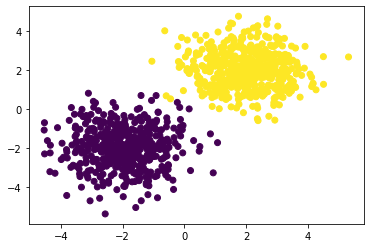

In [20]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)]).astype('int')
Y = Y.reshape(-1,1)
#Y = np.hstack([Y, 1-Y])
#print(Y.reshape(-1,1))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [21]:
epochs = 10
batch_size = 10
learning_rate = 1e-1


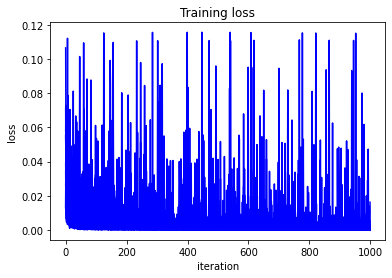

In [22]:
history = []
import time

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        #time.sleep(1)
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(model.layers[0].W[0][0])
        #print(loss)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [23]:
import os
from sklearn.datasets import fetch_openml
from sklearn import preprocessing

mnist = fetch_openml("mnist_784")
X = mnist.data / 255.0
y = mnist.target
np.savez('mnist.npz', X=X, y=y)

In [24]:
enc = preprocessing.OneHotEncoder(sparse=False)
y = np.array(y).reshape(-1,1).astype(int)
X = X.to_numpy()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, train_size=0.8)

In [25]:
X.shape

(70000, 784)

In [26]:
def accuracy(model, loader):
    total = 0
    correct = 0
    for X, y in loader:
        y_pred = model.forward(X)
        y = y.ravel()
        res = y_pred.argmax(axis=1)
        total += res.shape[0]
        correct += (res == y).sum()
    return correct / total

In [27]:
def SGD(params, gradients, lr=1e-3):
  res = []
  for i in range(len(params)):
    params[i] -= lr*gradients[i]
    return params

0.7759821428571428 0.7693571428571429
0.9672857142857143 0.9574285714285714
0.9770714285714286 0.9648571428571429
0.9844285714285714 0.9715714285714285
0.9881071428571429 0.9746428571428571
0.9903214285714286 0.9730714285714286
0.9923214285714286 0.975
0.9935714285714285 0.9772142857142857
0.995 0.9776428571428571
0.9952321428571429 0.977
0.9961964285714285 0.9772857142857143
0.9966964285714286 0.9778571428571429
0.9966964285714286 0.9770714285714286
0.9971964285714285 0.9780714285714286
0.9975357142857143 0.9795
0.9977142857142857 0.9791428571428571
0.997875 0.9784285714285714
0.9980892857142857 0.9792857142857143
0.9981964285714285 0.9790714285714286
0.9983392857142858 0.9791428571428571
0.998375 0.9790714285714286
0.9984285714285714 0.9788571428571429
0.9985714285714286 0.9792857142857143
0.9986071428571428 0.9799285714285715
0.9986428571428572 0.9798571428571429
0.9986785714285714 0.9793571428571428
0.9987142857142857 0.9795
0.9987321428571428 0.9802857142857143
0.9987321428571428 

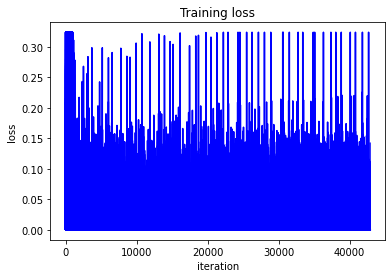

In [33]:
epochs = 50
batch_size = 64
learning_rate = 1e+2

d = 28*28

model = Sequential(
    Linear(28*28, d*2),
    ReLU(),
    Linear(d*2, 10),
    SoftMax()
)

criterion = CrossEntropy()

history = []
import time
l = loader(X_train, y_train, batch_size)
for i in range(1, epochs):
    for x, y_true in loader(X_train, y_train, batch_size):
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        history.append(loss)
    print(accuracy(model, loader(X_train, y_train, batch_size)), accuracy(model, loader(X_test, y_test, batch_size)))# accuracy(model,loader(X, Y, batch_size)))

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [34]:
accuracy(model,loader(X_test, y_test, batch_size))

0.98

In [ ]:
accuracy(model, X_train, y_train)